In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`
Precompiling project...
  ✓ YAXArrays
  ✓ EarthDataLab
  2 dependencies successfully precompiled in 8 seconds. 489 already precompiled.


# How to use YAXArrays.jl to do large scale raster computations


## Why Julia

* Interactive language
* High speed possible
* Most packages in Julia
* Lower barrier to package code

## Caveats for using Julia

* Relatively young language (10 years since 0.1 release and 5 years since 1.0)
* Smaller ecosystem compared to Python/R
* More rough edges
* Please open issues in the relevant packages to help smoothen these edges

## Why YAXArrays.jl

* Use data larger than RAM
* Load only the data that is really needed
* Use chunks of the data
* Use NetCDF or Zarr or GDAL to load data locally or from the cloud

# Understand chunking and rechunking

Task: Use your favorite NetCDF package and method to compute 

a) mean and 
b) median per spatial pixel

for the air_temperature_2m variable in this dataset without loading the whole data into memory (7GB uncompressed data per variable)

We first test access time along different axes:

## Load data in a map chunking

In [2]:
using NetCDF
using DiskArrays: eachchunk
tutorialdir = "/home/fcremer/Daten/Tutorials/"
vmap = NetCDF.open(joinpath(tutorialdir,"esdc_subset2_compressed.nc"),"layer")

Disk Array with size 1440 x 720 x 1794


In [163]:
first(eachchunk(vmap))

(1:1440, 1:720, 1:1)

In [3]:
@time vmap[:,:,1];

  0.763195 seconds (3.66 M allocations: 233.980 MiB, 10.43% gc time, 98.40% compilation time)


In [4]:
@time vmap[1,1,:];

 27.167968 seconds (407.20 k allocations: 23.341 MiB, 0.50% compilation time)


## Load data in Box chunking

In [ ]:
vbox = NetCDF.open(joinpath(tutorialdir,"esdc_subset_compressed.nc"),"layer")

In [164]:
first(eachchunk(vbox))

(1:90, 1:90, 1:184)

In [5]:
@time vbox[:,:,1];

  2.438017 seconds (34 allocations: 3.956 MiB)


In [6]:
@time vbox[1,1,:];

  0.237459 seconds (32 allocations: 8.312 KiB)


Access along spatial strides is much faster than access of time series
because of the internal storage in the netcdf file


DiskArrays.jl knows about the internal chunking structure and provides special implementations
for mapreduce which is used in the implementation of mean for AbstractArray
The following two aggregations access every chunk only once:


In [10]:

using Statistics
@time mean(vmap,dims=3);

@time mean(vmap,dims=(1,2));

 28.758307 seconds (1.82 M allocations: 7.047 GiB, 0.79% gc time, 2.19% compilation time)
 27.780490 seconds (332.72 k allocations: 6.949 GiB, 0.58% gc time, 0.57% compilation time)



This gets more difficult for the median, because here we need the full ts in memory.
This makes it impossible to compute the median in a single pass
Let's try this on a small subset


In [11]:

v2 = view(vmap,1:2, 1:2,:)
out = zeros(size(v2,1),size(v2,2))

@time for ilat in axes(v2,2), ilon in axes(v2,1)
    out[ilon,ilat] = median(v2[ilon,ilat,:])
end

104.821672 seconds (1.73 M allocations: 99.016 MiB, 0.02% gc time, 0.58% compilation time)



This already takes ages to finish for 4 grid cells only. It would be better to e.g. always read approx 1GB of data at a time and consecutively do the computations:

In [12]:
using ProgressMeter
out = zeros(size(vmap,1),size(vmap,2))
latsteps = 90
latranges = [(i*90-latsteps+1):(i*90) for i in 1:(720 ÷ latsteps)]


8-element Vector{UnitRange{Int64}}:
 1:90
 91:180
 181:270
 271:360
 361:450
 451:540
 541:630
 631:720

In [13]:
@showprogress for ilat in latranges
    out[:,ilat] = median(vmap[:,ilat,:],dims=3)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:38




This finishes in a reasonable amount of time. 
Alternatively we can use YAXArrays.jl which does exactly this workflow for a given cache size


In [14]:
using YAXArrays
ds = open_dataset(joinpath(tutorialdir, "esdc_subset_compressed.nc"))

ds.layer

1440×720×1748 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:lon} Sampled{Float64} -179.875:0.25:179.875 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 89.875:-0.25:-89.875 ReverseOrdered Regular Points,
  Ti Sampled{DateTime} DateTime[1980-01-05T00:00:00, …, 2017-12-31T00:00:00] ForwardOrdered Irregular Points
name: layer
units: W m-2
Total size: 6.75 GB


In [20]:
@time medtair = mapslices(median, ds.layer, dims="Time", max_cache=1e9)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


 70.344970 seconds (8.86 M allocations: 31.880 GiB, 5.44% gc time, 0.22% compilation time: 66% of which was recompilation)


1440×720 YAXArray{Union{Missing, Float32},2} with dimensions: 
  Dim{:lon} Sampled{Float64} -179.875:0.25:179.875 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 89.875:-0.25:-89.875 ReverseOrdered Regular Points
Total size: 3.96 MB


## Parellelize the data processing

In [27]:
using Distributed, Zarr
addprocs(4);

In [28]:
@everywhere begin 
    using Pkg
    Pkg.activate(".")
    Pkg.instantiate()
    #Pkg.status()
    using YAXArrays, Statistics, NetCDF, Zarr
end

  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`


      From worker 12:	  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`
      From worker 13:	  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`
      From worker 10:	  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`
      From worker 11:	  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`


In [23]:
@time medtair = mapslices(median, ds.layer, dims="Time", max_cache=1e9)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


 38.432237 seconds (13.53 k allocations: 996.570 KiB)


1440×720 YAXArray{Union{Missing, Float32},2} with dimensions: 
  Dim{:lon} Sampled{Float64} -179.875:0.25:179.875 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 89.875:-0.25:-89.875 ReverseOrdered Regular Points
Total size: 3.96 MB



YAXArrays will also take care of parallelization, for IO-limited processing tasks, we use Distributed.jl 

## Avoiding "slow" data access by re-chunking

When repeatedly accessing data in an un-optimal way, rechunking might be an option. For example when you plan to develop some new method and you know that it will have to access the data from the time direction. 

In [25]:
dsrechunked = setchunks(ds,(time=184,lat=90,lon=90))

YAXArray Dataset
Shared Axes: 
Dim{:lon} Sampled{Float64} -179.875:0.25:179.875 ForwardOrdered Regular Points,
Dim{:lat} Sampled{Float64} 89.875:-0.25:-89.875 ReverseOrdered Regular Points,
Ti Sampled{DateTime} DateTime[1980-01-05T00:00:00, …, 2017-12-31T00:00:00] ForwardOrdered Irregular Points
Variables: 
layer, 

In [29]:
savedataset(dsrechunked,path = joinpath(tutorialdir,"esdc_airtemp.zarr"), overwrite=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:05:47


YAXArray Dataset
Shared Axes: 
Dim{:lon} Sampled{Float64} -179.875:0.25:179.875 ForwardOrdered Regular Points,
Dim{:lat} Sampled{Float64} 89.875:-0.25:-89.875 ReverseOrdered Regular Points,
Ti Sampled{DateTime} DateTime[1980-01-05T00:00:00, …, 2017-12-31T00:00:00] ForwardOrdered Irregular Points
Variables: 
layer, 

In [30]:
rmprocs(workers())

Task (done) @0x00007fd31f5b28b0

Now we have created a new permanent copy of the dataset in zarr format and with relatively large chunks in time. This significantly speeds up computations along the time axis

In [34]:
ds = open_dataset(zopen(joinpath(tutorialdir, "esdc_airtemp.zarr"),fill_as_missing=false))
@time medtair = mapslices(median, ds.layer, dims="Time", max_cache=1e9)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


 41.617971 seconds (8.34 M allocations: 35.974 GiB, 9.48% gc time)


1440×720 YAXArray{Union{Missing, Float32},2} with dimensions: 
  Dim{:lon} Sampled{Float64} -179.875:0.25:179.875 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 89.875:-0.25:-89.875 ReverseOrdered Regular Points
Total size: 3.96 MB


# General introduction to YAXArrays.jl and mapCube

So far we have only used `mapslices` in this tutorial. However, this can only cover very simple cases for a single input cube and computations on one or dimensions which either collapse or return the same dimension. 

In [36]:
using EarthDataLab, DimensionalData, YAXArrays
using GLMakie

In [41]:
c = Cube(joinpath(tutorialdir,"esdc_subset2.zarr"))

1440×720×1748×5 YAXArray{Union{Missing, Float32},4} with dimensions: 
  Dim{:lon} Sampled{Float64} -179.875:0.25:179.875 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 89.875:-0.25:-89.875 ReverseOrdered Regular Points,
  Ti Sampled{DateTime} DateTime[1980-01-05T00:00:00, …, 2017-12-31T00:00:00] ForwardOrdered Irregular Points,
  Dim{:Variable} Categorical{String} String["air_temperature_2m", "land_surface_temperature", "gross_primary_productivity", "terrestrial_ecosystem_respiration", "net_ecosystem_exchange"] Unordered
units: W m-2
Total size: 33.76 GB


## The `mapCube` function

is a generalization of mapslices, where you can annotate the exact signature of the function to be applied. For example the computation of the `median` over time can be written using `mapCube`. 
Here one hase to specify the dimension(s) that the user-defined function is going to operate on. For the computation of the median over time the only input dimension is `time` and there are no output dimensions as only a single value is returned. The user defined function passed to `mapCube` always has the signature `f(outputs..., inputs...)` and potentially followd by additional arguments and keyword args. 

## Apply function along single Axis

In [42]:
using Statistics 
indims = InDims("time")
outdims = OutDims()
function apply_median(xout, xin)
    x = filter(!ismissing, xin)

    x = filter(!isnan,x)
    #@show x

    #filter!(!ismissing, x)
    xout[] = isempty(x) ? missing : median(x)
end

apply_median (generic function with 1 method)

In [44]:
medians = mapCube(apply_median, c[Variable=Where(contains("temp"))];indims, outdims)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


1440×720×2 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:lon} Sampled{Float64} -179.875:0.25:179.875 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 89.875:-0.25:-89.875 ReverseOrdered Regular Points,
  Dim{:Variable} Categorical{String} String["air_temperature_2m", "land_surface_temperature"] Unordered
Total size: 7.91 MB


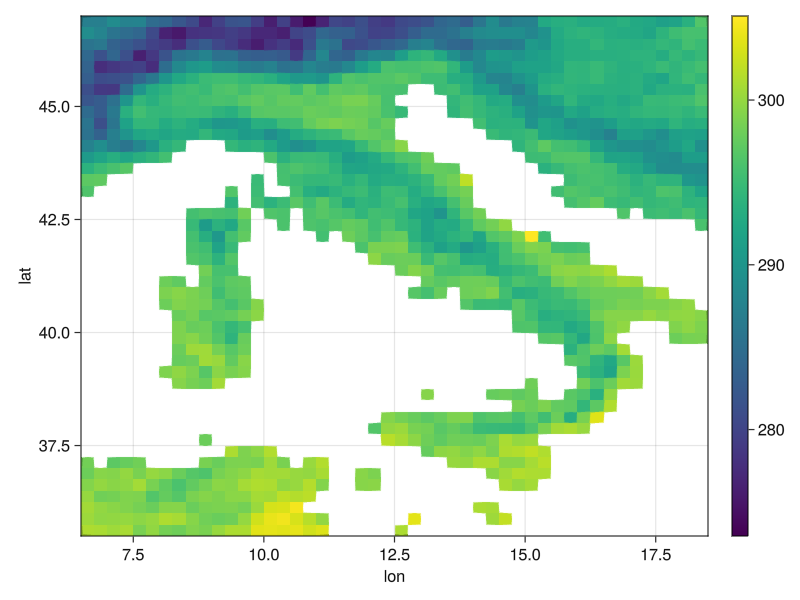

In [45]:
fig, ax, heat = heatmap(DimArray(medians[Variable=At("land_surface_temperature"), region="Italy"]))

## Apply function on all elements

In [69]:
medians_celsius = map(x-> x - 273.15, medians)

1440×720×2 YAXArray{Union{Missing, Float64},3} with dimensions: 
  Dim{:lon} Sampled{Float64} -179.875:0.25:179.875 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 89.875:-0.25:-89.875 ReverseOrdered Regular Points,
  Dim{:Variable} Categorical{String} String["air_temperature_2m", "land_surface_temperature"] Unordered
Total size: 15.82 MB


This function is applied lazily and only computed when the data is worked with. This could be a mapCube operation, saving the data to disk or plotting the data. 

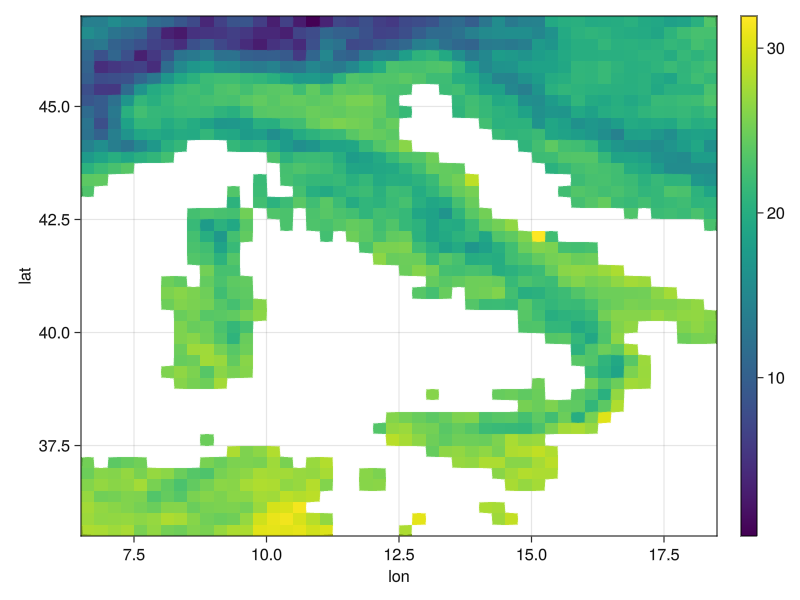

In [70]:
heatmap(DimArray(medians_celsius[Variable=At("land_surface_temperature"), region="Italy"]))

In [54]:
using Distances
function tau_recurrence(ts::AbstractVector, thresh, metric=Euclidean())
    n = length(ts)
    rr_τ = zeros(n)
    for col in 1:n
        for row in 1:(col - 1)
            d = evaluate(metric, ts[col], ts[row])
            #@show row, col, d
            rr_τ[col-row + 1] += d <= thresh
        end
    end
    rr_τ[1] = n
    rr_τ ./ (n:-1:1)
    #rr_τ
end

tau_recurrence (generic function with 2 methods)

## Arguments for inner function and output dimensions

In [71]:
using RecurrenceAnalysis: RecurrenceAnalysis as RA
function rqatrend(pix_trend, pix, thresh=2)
    ts = collect(skipmissing(pix))
    tau_pix = tau_recurrence(ts,thresh)
    pix_trend .= RA._trend(tau_pix)
end

function rqatrend(cube; thresh=2, path=tempname() * ".zarr", overwrite=false)
    mapCube(rqatrend, cube, thresh; indims=InDims("Time"), outdims=OutDims(;outtype=Float16, path, overwrite))
end
#rqatemp = rqatrend(c[Variable=Where(contains("temp"))], thresh=1)

rqatrend (generic function with 3 methods)

Let's make a slightly more complex computation to demonstrate a case where multiple outputs are generated. For examples, imagine we want to normalize every time series (to zero mean and unit variance), but at the same time return the means and variances in a single dataset for later re-use:

## Apply function with multiple output cubes

In [ ]:
function norm(ts_out, mean_out, std_out, ts_in)
    x = filter(!ismissing, ts_in)

    tsshort = filter(!isnan,x)
    if isempty(tsshort)
        ts_out .= missing
        mean_out[] = missing
        std_out[] = missing
    else
        mean_out[] = mean(tsshort)
        std_out[] = std(tsshort)
        ts_out .= (ts_in .- mean_out[])./std_out[]
    end
end

In [72]:
indims = InDims("Time")
od_ts = OutDims("Time",path = "./normalized_ts.zarr",
                backend=:zarr,overwrite=true)
od_m = OutDims(path = "./means.nc",backend=:netcdf, overwrite=true)
od_s = OutDims(path = "./stds.nc",backend=:netcdf, overwrite=true)
outdims = (od_ts, od_m, od_s)
tsnorm, means, stds = mapCube(norm,c[Variable=Where(contains("temp")),
                    region="Italy"],indims=indims, outdims=outdims);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


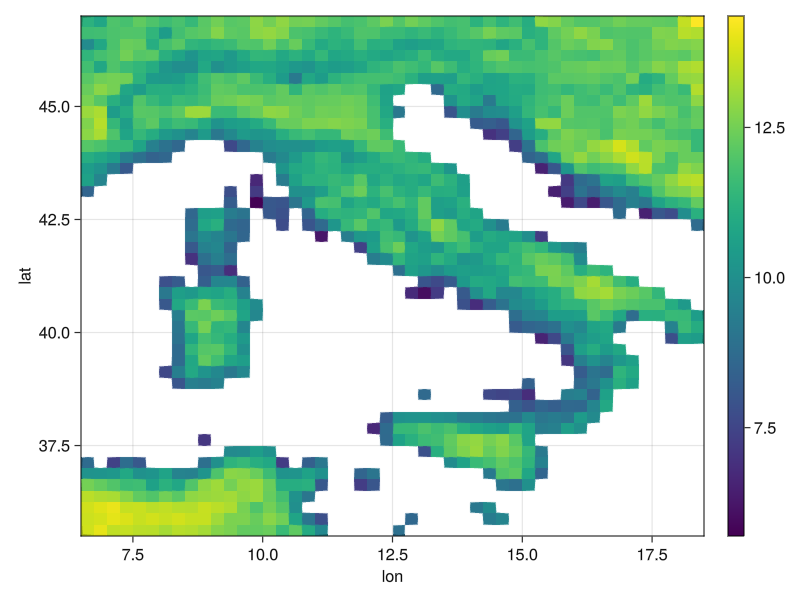

In [113]:
heatmap(DimArray(stds[Variable=At("land_surface_temperature")]))

## Apply function on moving window

In [122]:
function meanfilter(xout, xin)
    if ismissing(xin[2,2])
        xout .= missing
    else
    xout .= mean(skipmissing(xin))
    end
end

meanfilter (generic function with 1 method)

In [123]:
indims = InDims(MovingWindow("lon", 3,3),MovingWindow("lat", 3, 3))

InDims((MovingWindow(YAXArrays.ByName("lon"), 3, 3), MovingWindow(YAXArrays.ByName("lat"), 3, 3)), Array, (YAXArrays.DAT.AllMissing(),), missing)

In [124]:
stds

48×46×2 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:lon} Sampled{Float64} 6.625:0.25:18.375 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 46.875:-0.25:35.625 ReverseOrdered Regular Points,
  Dim{:Variable} Categorical{String} String["air_temperature_2m", "land_surface_temperature"] Unordered
Total size: 17.25 KB


In [127]:
filteredmeans = mapCube(meanfilter, means, indims=indims, outdims=OutDims())

48×46×2 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:lon} Sampled{Float64} 6.625:0.25:18.375 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 46.875:-0.25:35.625 ReverseOrdered Regular Points,
  Dim{:Variable} Categorical{String} String["air_temperature_2m", "land_surface_temperature"] Unordered
Total size: 17.25 KB


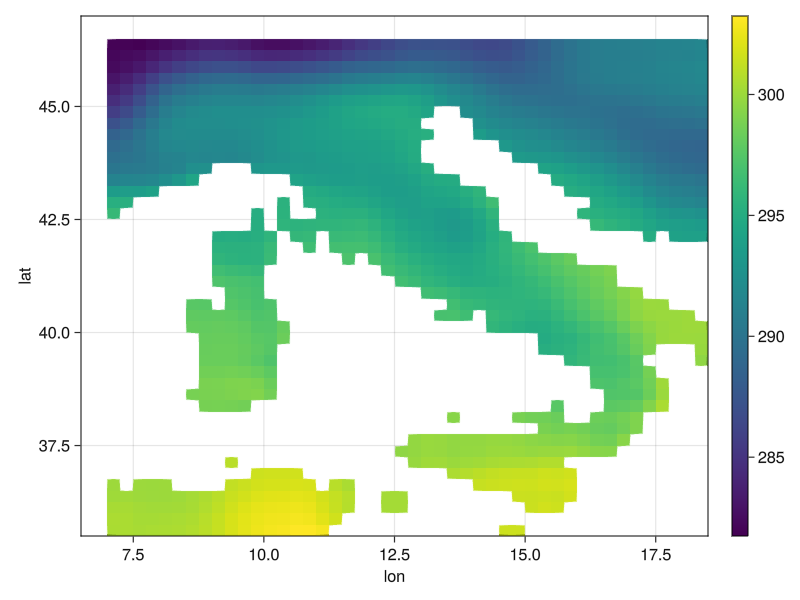

In [128]:
heatmap(DimArray(filteredstds[Variable=At("land_surface_temperature")]))

## Define new output dimensions

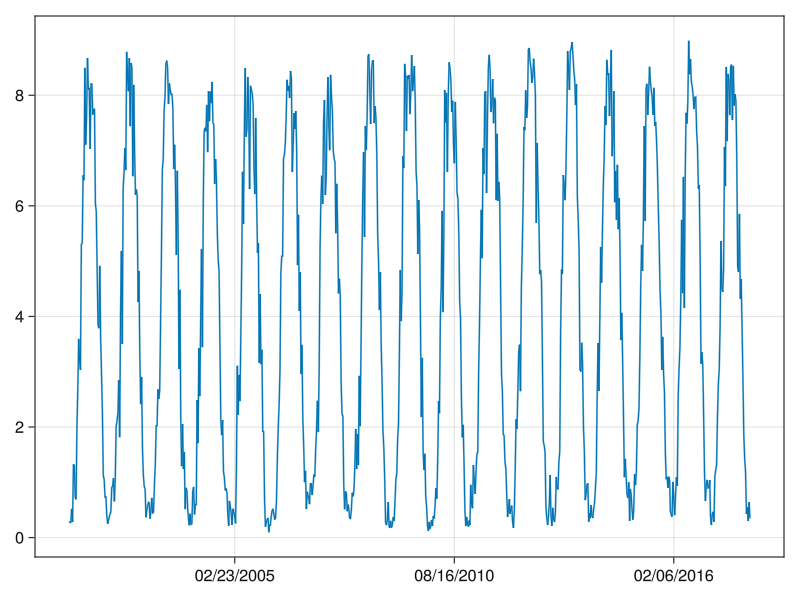

In [81]:
using Dates
dateformatfun(x) = Dates.format.(rata2datetime.(x), "mm/dd/yyyy")
gpp = c[Variable=At("gross_primary_productivity"),
        time=Date(2001)..Date(2018,12,31), 
        lon=Near(11.3464),lat=Near(46.4946)]
fig,ax, pl = lines(datetime2rata.(lookup(gpp, Ti).data),gpp.data)
ax.xtickformat = dateformatfun
fig


So far the function applied here were very simple statistics. Just to stress again, that we are running arbitrary Julia code here, so for example if we want to use some package for time series decomposition like `Forecast.jl`:

In [80]:
using Forecast
stlres = stl(gpp.data[:],46,robust=true,verbose=false,
            timestamp=lookup(gpp, Ti).data)


LoadError: UndefVarError: `tempbozen` not defined

In [78]:
function plot_stlres(t, org, stlres)
    fig = Figure()
    axorg = Axis(fig[1,1], title="Original data")
    axseas = Axis(fig[2,1], title="Seasonal")
    axtrend = Axis(fig[3,1], title="Trend")
    axrem = Axis(fig[4,1], title="Remainder")
    lines!(axorg,t, org)
    lines!(axseas, t, stlres.decomposition[!,:Seasonal])
    lines!(axtrend, t, stlres.decomposition[!, :Trend])
    lines!(axrem, t, stlres.decomposition[!, :Remainder])
    hidexdecorations!.([axorg, axseas, axtrend], grid=false)
    axrem.xtickformat = dateformatfun
    fig
end

plot_stlres (generic function with 2 methods)

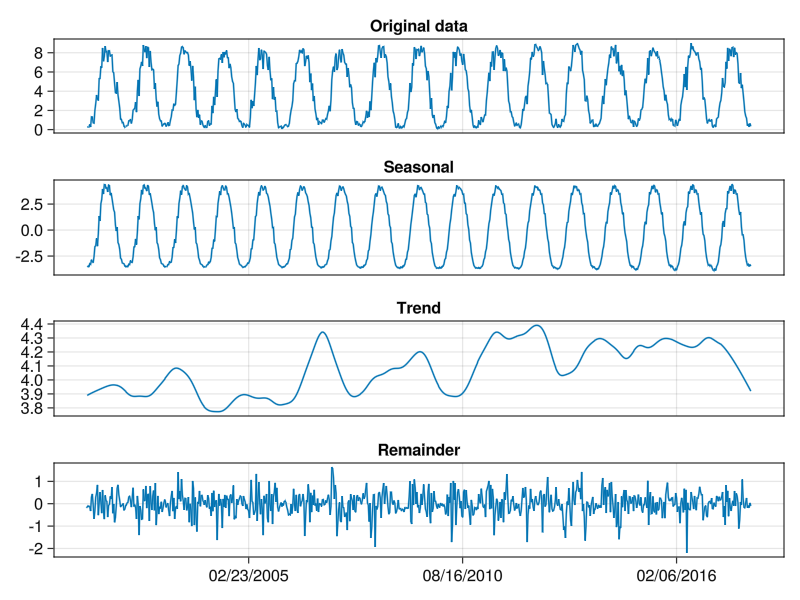

In [79]:
t = datetime2rata.(stlres.decomposition[!,:Timestamp])
plot_stlres(t, gpp, stlres)

In order to apply this over a full array we define the usual Trio: indims, outdims and the function to be applied. Here we create a new dimension for the output. There are 2 types of axes in YAXArrays, `CategoricalAxis` for unordered and `RangeAxis` for ordered dimensions. Here we create a categorical axis for our outputs. This means that inside the function the input array `xin` is a vector with of length `n_timesteps` and the output is a matrix of size `n_timesteps x 3` 

In [91]:
import Logging
Logging.disable_logging(Logging.Info)
indims = InDims("time")
outdims = OutDims("time",Dim{:Scale}(["Seasonal", "Trend", "Remainder"]), 
                    path = "decomposed.zarr",backend=:zarr, overwrite=true)
function decompose_TS(xout, xin)
    any(isnan,xin) && return xout .= missing
    stlres = stl(xin,46,robust=false,verbose=false)
    _,seas,trend,rem = eachcol(stlres.decomposition)
    xout[:,1] = seas
    xout[:,2] = trend
    xout[:,3] = rem
end

decompose_TS (generic function with 1 method)

In [95]:
using Logging
Logging.disable_logging(Warn)


In [96]:
@time dec = mapCube(decompose_TS, 
    c[Variable=At("gross_primary_productivity"),
        time=Date(2001)..Date(2018,12,31),
        region="Italy"],
        #lon=Near(11.3464),lat=Near(46.4946)],
    indims = indims,
    outdims = outdims
)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:11


131.577868 seconds (204.94 M allocations: 576.936 GiB, 22.72% gc time)


782×3×48×46 YAXArray{Union{Missing, Float32},4} with dimensions: 
  Ti Sampled{DateTime} DateTime[2001-01-05T00:00:00, …, 2017-12-31T00:00:00] ForwardOrdered Irregular Points,
  Dim{:Scale} Categorical{String} String["Seasonal", "Trend", "Remainder"] Unordered,
  Dim{:lon} Sampled{Float64} 6.625:0.25:18.375 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 46.875:-0.25:35.625 ReverseOrdered Regular Points
Total size: 19.76 MB


In [97]:
Logging.disable_logging(Debug)

LogLevel(-999)

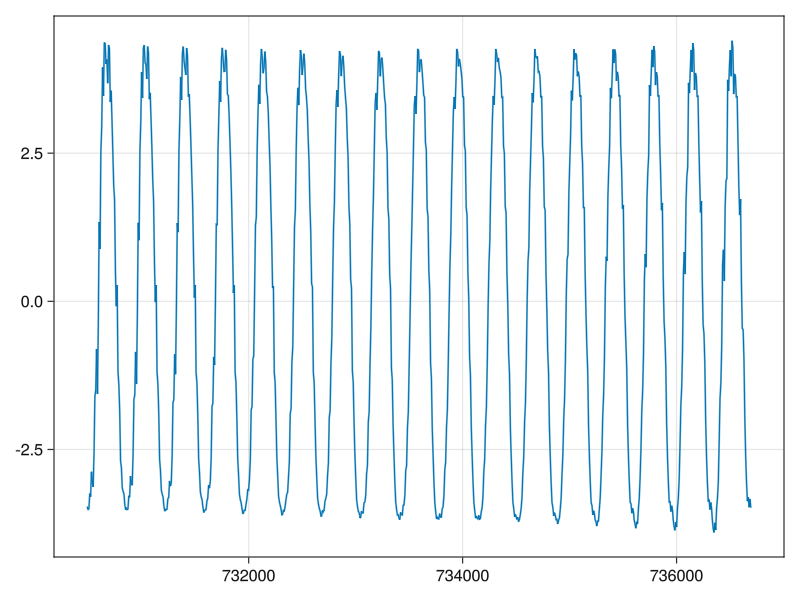

In [99]:
fig, axseas, heatyax = lines( datetime2rata.(lookup(dec, Ti).data),
    dec[lon=Near(11.3464),lat=Near(46.4946)].data[:,1])
fig

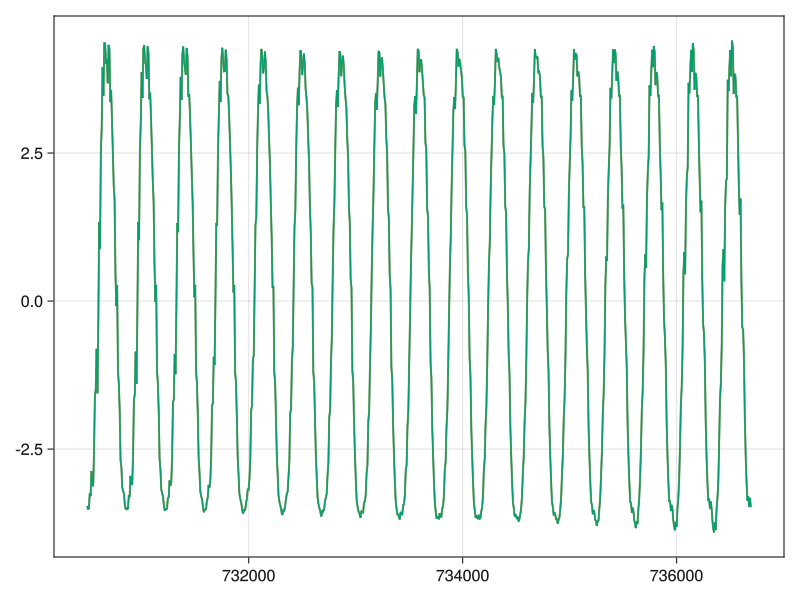

In [101]:
lines!(datetime2rata.(lookup(dec, Ti).data),
    stlres.decomposition[!, :Seasonal])
fig

You see that the resulting array is a 4-dimensional array including the newly created axis. Lets do some plots:

In [109]:
#Compute variance and plot a map of seasonal variance
scalevar = mapslices(var,dec,dims="Time")
scalerange = mapslices(x->maximum(x) - minimum(x), dec, dims="Time")


3×48×46 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:Scale} Categorical{String} String["Seasonal", "Trend", "Remainder"] Unordered,
  Dim{:lon} Sampled{Float64} 6.625:0.25:18.375 ForwardOrdered Regular Points,
  Dim{:lat} Sampled{Float64} 46.875:-0.25:35.625 ReverseOrdered Regular Points
Total size: 25.88 KB


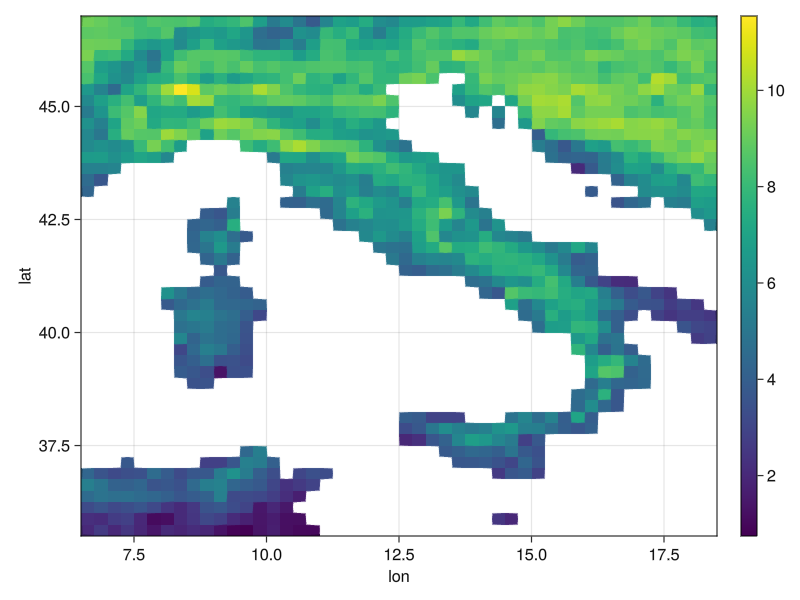

In [110]:
heatmap(DimArray(scalerange[scale=At("Seasonal")]))

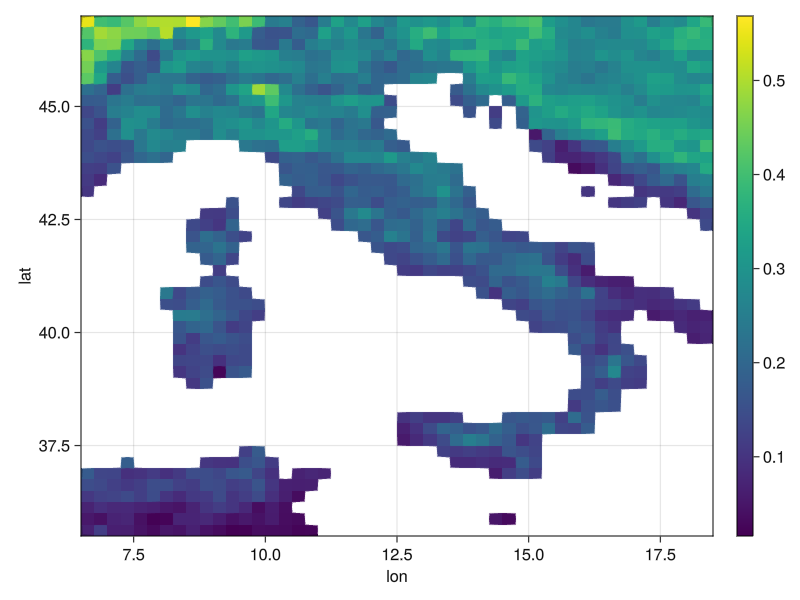

In [111]:
heatmap(DimArray(scalevar[scale=At("Remainder")]))

## Interpolate data on finer grids

In [ ]:
using Revise,EarthDataLab, DimensionalData,Rasters, Interpolations
#c = esdd()
ds = open_dataset(joinpath(tutorialdir,"esdc_subset2.zarr"))
tair = ds.air_temperature_2m

newlons = -179.95:0.1:179.95
newlats = -89.95:0.1:89.95

#Option 1:
tair1 = spatialinterp(tair,newlons,newlats, order =Quadratic())

tair1[lon=10..15, lat=50..60]

tair1italy = tair1[region="Italy",time=Near(DateTime(2015,6,1))]


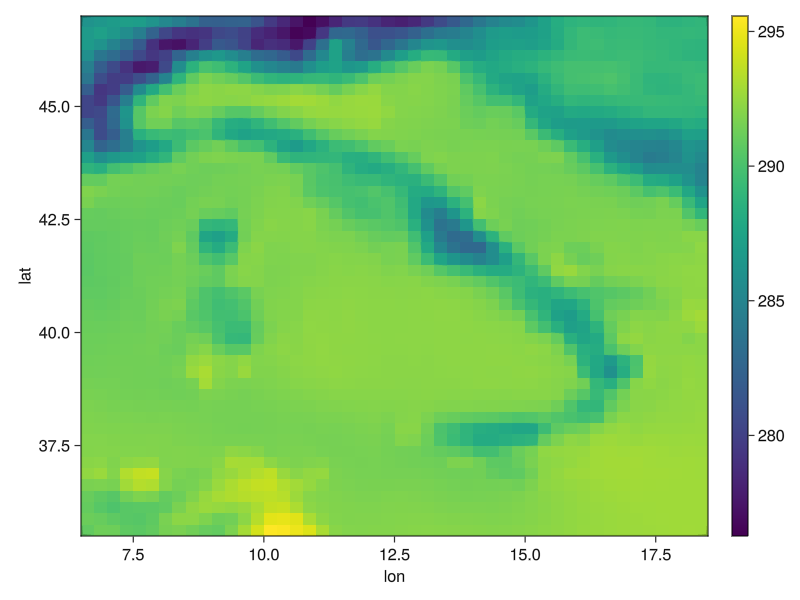

In [145]:
heatmap(DimArray(tair[region="Italy", time=Near(DateTime(2015,6,1))]))

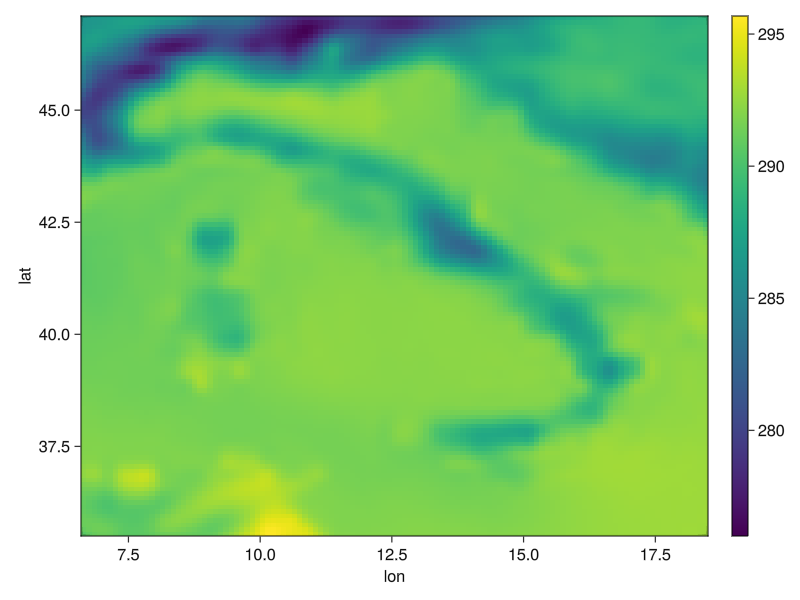

In [146]:
figinterp, interpax, interpheat = heatmap(DimArray(tair1italy))

ii = [(:time, 3)]
ai = nothing
ai = nothing
ai = 1
ii[ai] = (:time, 3)
intorder = (NoInterp(), NoInterp(), Quadratic(Line(OnGrid())))


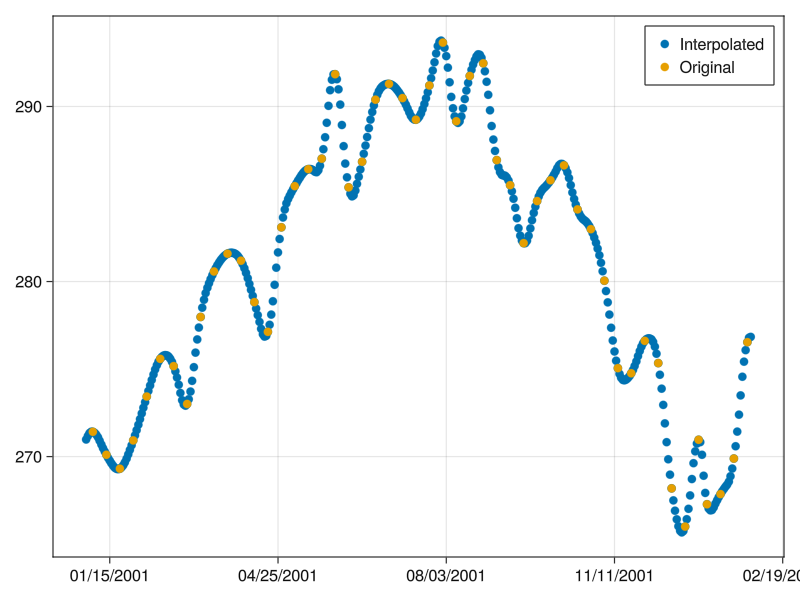

In [151]:
using Dates
newtimes = DateTime(1979):Day(1):DateTime(2021,12,31)
tair2 = interpolatecube(tair,Dict(:time=>newtimes), order=Dict(:time=>Quadratic()))
tair2Jan = tair2[time=DateTime(2001)..DateTime(2002,1,31), lon=Near(11.3464),lat=Near(46.4946)]
tairJan = tair[time=DateTime(2001)..DateTime(2002,1,31), lon=Near(11.3464),lat=Near(46.4946)]

fig, ax, pl = scatter(datetime2rata.(lookup(tair2Jan, Ti).data), tair2Jan.data[:],label="Interpolated")
scatter!(datetime2rata.(lookup(tairJan, Ti).data), tairJan.data[:], label="Original")
ax.xtickformat = dateformatfun
axislegend(ax)
fig

## Use Python or R in inner function

In [153]:
using PyCall
scipyndimage = pyimport("scipy.ndimage")

PyObject <module 'scipy.ndimage' from '/home/fcremer/.julia/conda/3/lib/python3.9/site-packages/scipy/ndimage/__init__.py'>

In [154]:
function gaussian_smooth(xout, xin)
    missinds = ismissing.(xin)
    smooth = scipyndimage.gaussian_filter(xin[.!missinds], sigma=4)
    xout[.!missinds] .= smooth
end

gaussian_smooth (generic function with 1 method)

In [156]:
gpp_bozen_2010 = c[lon=Near(11.3464),lat=Near(46.4946),
    time = DateTime(2010)..DateTime(2011),
    Variable=At("gross_primary_productivity")]

46-element YAXArray{Union{Missing, Float32},1} with dimensions: 
  Ti Sampled{DateTime} DateTime[2010-01-05T00:00:00, …, 2010-12-31T00:00:00] ForwardOrdered Irregular Points
units: W m-2
Total size: 184.0 bytes


In [158]:
smoothcube = mapCube(gaussian_smooth, gpp_bozen_2010, indims=InDims("time"), outdims=OutDims("time"))

46-element YAXArray{Union{Missing, Float32},1} with dimensions: 
  Ti Sampled{DateTime} DateTime[2010-01-05T00:00:00, …, 2010-12-31T00:00:00] ForwardOrdered Irregular Points
Total size: 184.0 bytes


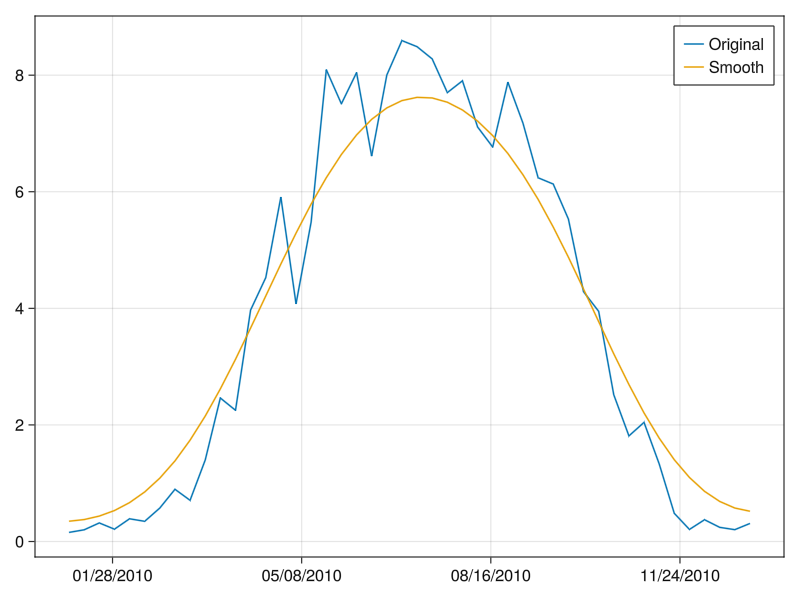

In [162]:
fig, ax, l = lines(datetime2rata.(lookup(gpp_bozen_2010, Ti).data), gpp_bozen_2010[:], label="Original")
lines!(ax,datetime2rata.(lookup(smoothcube, Ti).data), smoothcube[:], label="Smooth")
ax.xtickformat= dateformatfun
axislegend(ax)
fig


# Creating a SAR data cube from GDAL VRTs



- Combine multiple Tif files into one data cube for time series analysis 
- Use Sentinel-1 data as an example

In [28]:
using Dates
using ArchGDAL: ArchGDAL as AG
using YAXArrays
using DimensionalData

In [16]:
folder = "/home/fcremer/Daten/Tutorials/s1data"
pol = "VH"
allfiles = Iterators.flatten([joinpath.((t[1],), t[3]) for t in walkdir(folder)])
nonhiddenfiles = Iterators.filter(x->!startswith(basename(x),"."), allfiles)
filteredfiles = collect(Iterators.filter(x->occursin(pol,x), nonhiddenfiles))


4-element Vector{String}:
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "228_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "253_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "244_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "309_127_VH_grd_mli_norm_geo.tif"

In [17]:
using Dates
function getdate(x,reg = r"[0-9]{8}T[0-9]{6}", df = dateformat"yyyymmddTHHMMSS")
   m = match(reg,x).match
   date =DateTime(m,df)
end
dates = getdate.(filteredfiles)

4-element Vector{DateTime}:
 2016-10-03T10:12:28
 2016-10-03T10:12:53
 2020-01-16T10:12:44
 2020-01-16T10:13:09

In [18]:
p = sortperm(dates)
sdates = dates[p]
sfiles = filteredfiles[p]


4-element Vector{String}:
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "228_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "253_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "244_127_VH_grd_mli_norm_geo.tif"
 "/home/fcremer/Daten/Tutorials/s" ⋯ 30 bytes ⋯ "309_127_VH_grd_mli_norm_geo.tif"

In [19]:
"""
grouptimes(times, timediff=200000)
Group a sorted vector of time stamps into subgroups
where the difference between neighbouring elements are less than `timediff` milliseconds.
This returns the indices of the subgroups as a vector of vectors.
"""
function grouptimes(times, timediff=200000)
   @assert sort(times) == times
   group = [1]
   groups = [group]

   for i in 2:length(times)
      t = times[i]
      period = t - times[group[end]]
      if period.value < timediff
         push!(group, i)
      else
         push!(groups, [i])
         group = groups[end]
      end
   end
   return groups
end

groupinds = grouptimes(sdates, 200000)


2-element Vector{Vector{Int64}}:
 [1, 2]
 [3, 4]

In [21]:
datasets = AG.read.(sfiles)
datasetgroups = [datasets[group] for group in groupinds]
#We have to save the vrts because the usage of nested vrts is not working as a rasterdataset

2-element Vector{Vector{ArchGDAL.IDataset}}:
 [GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5816 x 4326 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 5816 x 4326 (Float32)
, GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20161003T101253_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 4596 x 5043 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 4596 x 5043 (Float32)
]
 [GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5815 x 4325 (pixels)
Number of raster bands: 1
  [GA_ReadOnly] Band 1 (Gray): 5815 x 4325 (Float32)
, GDAL Dataset (Driver: GTiff/GeoTIFF)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20200116T101309_127_VH_grd_mli_norm_geo.

In [29]:
temp = tempdir()
outpaths = [joinpath(temp, splitext(basename(sfiles[group][1]))[1] * ".vrt") for group in groupinds]
vrt_grouped = AG.unsafe_gdalbuildvrt.(datasetgroups)

2-element Vector{ArchGDAL.Dataset}:
 GDAL Dataset (Driver: VRT/Virtual Raster)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.tif
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20161003T101253_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5816 x 7500 (pixels)
Number of raster bands: 1
  [GA_Update] Band 1 (Gray): 5816 x 7500 (Float32)

 GDAL Dataset (Driver: VRT/Virtual Raster)
File(s): 
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.tif
  /home/fcremer/Daten/Tutorials/s1data/S1A__IW___D_20200116T101309_127_VH_grd_mli_norm_geo.tif

Dataset (width x height): 5815 x 7500 (pixels)
Number of raster bands: 1
  [GA_Update] Band 1 (Gray): 5815 x 7500 (Float32)


In [23]:
AG.write.(vrt_grouped, outpaths)
vrt_grouped = AG.read.(outpaths)
vrt_vv = AG.unsafe_gdalbuildvrt(vrt_grouped, ["-separate"])
rvrt_vv = AG.RasterDataset(vrt_vv)

GDAL Dataset (Driver: VRT/Virtual Raster)
File(s): 
  /tmp/S1A__IW___D_20161003T101228_127_VH_grd_mli_norm_geo.vrt
  /tmp/S1A__IW___D_20200116T101244_127_VH_grd_mli_norm_geo.vrt

Dataset (width x height): 5816 x 7500 (pixels)
Number of raster bands: 2
  [GA_Update] Band 1 (Undefined): 5816 x 7500 (Float32)
  [GA_Update] Band 2 (Undefined): 5816 x 7500 (Float32)


In [24]:
cube=YAXArray(rvrt_vv)
#bandnames = AG.GDAL.gdalgetfilelist(vrt_vv.ptr)

5816×7500×2 YAXArray{Float32,3} with dimensions: 
  Dim{:Y} Sampled{Float64} 561609.15:30.0:736059.15 ForwardOrdered Regular Points,
  Dim{:X} Sampled{Float64} 9.48724066e6:-30.0:9.26227066e6 ReverseOrdered Regular Points,
  Dim{:Band} Categorical{String} String["Band_1", "Band_2"] ForwardOrdered
Total size: 332.79 MB


In [76]:
# Set the timesteps from the bandnames as time axis
dates_grouped = [sdates[group[begin]] for group in groupinds]

taxis = Ti(dates_grouped)
cube = YAXArrays.Cubes.renameaxis!(cube, "Band"=>taxis)

5816×7500×2 YAXArray{Float32,3} with dimensions: 
  Dim{:Y} Sampled{Float64} 561609.15:30.0:736059.15 ForwardOrdered Regular Points,
  Dim{:X} Sampled{Float64} 9.48724066e6:-30.0:9.26227066e6 ReverseOrdered Regular Points,
  Ti Categorical{DateTime} DateTime[DateTime("2016-10-03T10:12:28"), DateTime("2020-01-16T10:12:44")] ForwardOrdered
Total size: 332.79 MB


In [77]:
YAXArrays.Cubes.cubechunks(cube)

(128, 128, 1)

In [78]:
newchunked = setchunks(cube, (X=400,Y=400, Time=2))

5816×7500×2 YAXArray{Float32,3} with dimensions: 
  Dim{:Y} Sampled{Float64} 561609.15:30.0:736059.15 ForwardOrdered Regular Points,
  Dim{:X} Sampled{Float64} 9.48724066e6:-30.0:9.26227066e6 ReverseOrdered Regular Points,
  Ti Categorical{DateTime} DateTime[DateTime("2016-10-03T10:12:28"), DateTime("2020-01-16T10:12:44")] ForwardOrdered
Total size: 332.79 MB


In [79]:
YAXArrays.Cubes.cubechunks(newchunked)

(400, 400, 2)

In [36]:
savecube(newchunked, "s1data.nc")

UndefVarError: UndefVarError: `newchunked` not defined

# 3. YAXArrays table-interface

Similar to Rasters.jl, also YAXArrays provides a method to represent labelled arrays as a table. However, as everything in YAXArrays, lazy is the default as well for tables. So the CubeTable constructor will not load any data but will provide an iterator over table chunks that one can use for further analysis. Here it is guaranteed that these subtables fit into memory and they can be distributed for parallel data loading and processing

In [61]:
using Revise, YAXArrays, Zarr, Plots
ds = open_dataset("./esdc_subset2.zarr")

countryds = open_dataset("./countries.zarr")
countryds.countries.properties["labels"] = Dict(parse(Int,k)=>v for (k,v) in countryds.countries.properties["labels"])
countryds.countries.properties["Name"] = "Country"
countryds.countries

ArgumentError: ArgumentError: Package Plots not found in current path.
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.

In [62]:

tab = CubeTable(gpp = ds.gross_primary_productivity, tair = ds.air_temperature_2m, country = countryds.countries)


UndefVarError: UndefVarError: `ds` not defined

It is possible to loop over or index into a table iterator to get one of the subtables or . Note that even here nothing is loaded yet. 

In [63]:
subtab = tab[42]

UndefVarError: UndefVarError: `tab` not defined

Only when accessing a specific column, the data is actually loaded

In [64]:
subtab.tair

UndefVarError: UndefVarError: `subtab` not defined

But since a subtable implements the Tables interface we can also convert to a DataFrame

In [65]:
using DataFrames
DataFrame(subtab)

ArgumentError: ArgumentError: Package DataFrames not found in current path.
- Run `import Pkg; Pkg.add("DataFrames")` to install the DataFrames package.

These tables can be used for aggregating data. Suppose we want to compute the mean temperature by country, YAXArrays provides some tools to do this in connection with OnlineStats.jl and WeightedOnlineStats.jl

In [66]:
using WeightedOnlineStats, OnlineStats
#using Distributed
#addprocs(8)

ArgumentError: ArgumentError: Package WeightedOnlineStats not found in current path.
- Run `import Pkg; Pkg.add("WeightedOnlineStats")` to install the WeightedOnlineStats package.

In [67]:
#@everywhere begin
    using Pkg
    Pkg.activate(".")
    using YAXArrays, Zarr, Plots, WeightedOnlineStats, OnlineStats, Dates
#end

  Activating project at `~/Documents/conferences/202310_Bozen_OEMC_GW23`


ArgumentError: ArgumentError: Package Plots not found in current path.
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.

In [68]:
@time r = cubefittable(tab, WeightedMean, :tair, by=(:country,),weight=(r->cosd(r.lat)))

UndefVarError: UndefVarError: `tab` not defined

In [69]:
DataFrame(first(CubeTable(mtemp = r)))

UndefVarError: UndefVarError: `r` not defined

In [70]:
@everywhere splitmonth(r) = month(r.time)
r = cubefittable(tab, WeightedMean, :tair, by=(:country,splitmonth),weight=(r->cosd(r.lat)))

UndefVarError: UndefVarError: `tab` not defined

In [71]:
rmprocs(workers())

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /home/fcremer/.julia/juliaup/julia-1.9.2+0.x64.linux.gnu/share/julia/stdlib/v1.9/Distributed/src/cluster.jl:1049


Task (done) @0x00007ffab00d95f0